1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [ ]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [2]:
import pandas as pd
data = pd.read_csv('data/data_000637.txt').head(15000)             #read the dataset and choose 15k for rows
dp = pd.DataFrame(data)
print(dp)

       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0         1     0          123  3869200167        2374        26
1         1     0          124  3869200167        2374        27
2         1     0           63  3869200167        2553        28
3         1     0           64  3869200167        2558        19
4         1     0           64  3869200167        2760        25
...     ...   ...          ...         ...         ...       ...
14995     1     1            4  3869200316        3399         9
14996     1     1           17  3869200316        3400        15
14997     1     1           10  3869200316        3530        16
14998     1     1            8  3869200316        3533        18
14999     1     0          139  3869200316        3539         0

[15000 rows x 6 columns]


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [3]:
data_bx = data["BX_COUNTER"]
estimated_bx = max(data_bx) +1
print("Estimated number of BX in a ORBIT:", estimated_bx)

Estimated number of BX in a ORBIT: 3564


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [4]:
data["abs_time_ns"] = data['TDC_MEAS'] *(25 / 30) + data['BX_COUNTER'] * 25 +data['ORBIT_CNT']*estimated_bx*25

data["abs_time_ns"] = pd.to_datetime(data["abs_time_ns"])
dp.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   HEAD         15000 non-null  int64         
 1   FPGA         15000 non-null  int64         
 2   TDC_CHANNEL  15000 non-null  int64         
 3   ORBIT_CNT    15000 non-null  int64         
 4   BX_COUNTER   15000 non-null  int64         
 5   TDC_MEAS     15000 non-null  int64         
 6   abs_time_ns  15000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(6)
memory usage: 820.4 KB


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [5]:
import datetime as dt

itime = dt.datetime.now()
print("Begin time:", itime)

# the one-liner command
time =  data['TDC_MEAS'] *(25/30) + data['BX_COUNTER'] * 25 + data['ORBIT_CNT']*estimated_bx*25

ftime = dt.datetime.now()
print("End time:", ftime)
print("Elapsed time:", (ftime - itime))

Begin time: 2022-12-02 13:47:17.367148
End time: 2022-12-02 13:47:17.370140
Elapsed time: 0:00:00.002992


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [6]:
grouped =  data.groupby('TDC_CHANNEL').sum().sort_values(by = ['HEAD']).iloc[-3:]
grouped

,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS
TDC_CHANNEL,,,,,
63,749,6,2898030982000,1364359,11085
64,752,17,2909638583165,1394717,10889
139,1268,389,4906145905369,2247027,0


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [7]:
DF=data[data['TDC_CHANNEL']==139]
print(DF)

       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
7         1     0          139  3869200167        2776         0   
15        1     1          139  3869200167        2797         0   
30        1     0          139  3869200167        3085         0   
39        1     0          139  3869200167        3186         0   
48        1     0          139  3869200168          23         0   
...     ...   ...          ...         ...         ...       ...   
14956     1     0          139  3869200316         285         0   
14970     1     0          139  3869200316        1001         0   
14985     1     0          139  3869200316        3389         0   
14989     1     1          139  3869200316        3398         0   
14999     1     0          139  3869200316        3539         0   

                        abs_time_ns  
7     1970-01-04 23:45:45.734949100  
15    1970-01-04 23:45:45.734949625  
30    1970-01-04 23:45:45.734956825  
39    1970-01-04 23:45:45.73495

7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [8]:
DF=DF.ORBIT_CNT.nunique() 
print(DF)

150


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [14]:
fpga_0 = pd.Series(data[data['FPGA']==0]['TDC_CHANNEL'].value_counts()) ##selecting FPGA with number 0 and counting each instance of TDC_CHANNEL value
fpga_1 = pd.Series(data[data['FPGA']==1]['TDC_CHANNEL'].value_counts()) ##selecting FPGA with number 1 and counting each instance of TDC_CHANNEL value
print("The FPGA identified with 0:\n", fpga_0)

The FPGA identified with 0:
 139    879
63     743
64     735
61     555
62     529
      ... 
99       5
107      5
98       5
106      4
101      3
Name: TDC_CHANNEL, Length: 117, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

Text(0, 0.5, 'Count')

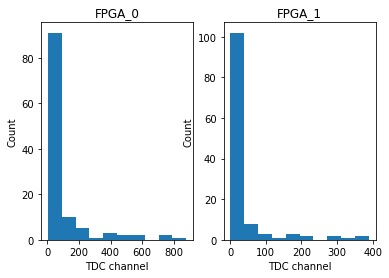

In [15]:
import matplotlib.pyplot as plt
a = data.groupby('TDC_CHANNEL').count()['FPGA']
fig, (ax1, ax2, ) = plt.subplots(1, 2,)

ax1.hist(fpga_0) ##create histogtram
ax1.set_title('FPGA_0')
ax1.set_xlabel('TDC channel')
ax1.set_ylabel('Count')

ax2.hist(fpga_1)
ax2.set_title('FPGA_1')
ax2.set_xlabel('TDC channel')
ax2.set_ylabel('Count')